# Step 1: Prepare Dataset

This cell prepares the dataset for training YOLOv8 for face mask detection.  
The main tasks are:
- Define paths for images, annotations, and dataset folders.
- Create necessary folders for training and validation sets (images and labels).
- Map class names ("with_mask", "without_mask", "mask_weared_incorrect") to numerical labels.
- List all images in the dataset and shuffle them.
- Split the images into training (80%) and validation (20%) sets.


In [2]:
import os
import random
import shutil
import xml.etree.ElementTree as ET

annotations_path = r'F:\FaceMaskDetection_Jupyter\annotations'
images_path      = r'F:\FaceMaskDetection_Jupyter\images'
dataset_path     = r'F:\FaceMaskDetection_Jupyter\dataset'

# Create folders
for sub in ['images/train', 'images/val', 'labels/train', 'labels/val']:
    os.makedirs(os.path.join(dataset_path, sub), exist_ok=True)

label_map = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2
}

all_images = [f for f in os.listdir(images_path) if f.endswith(('.jpg','.png'))]
print(f"Found {len(all_images)} images")
random.shuffle(all_images)

split_idx = int(0.8 * len(all_images))
train_files = all_images[:split_idx]
val_files   = all_images[split_idx:]


Found 853 images


# Step 2: Convert Annotations and Copy Images

This cell defines a function `convert_and_copy` that processes each image and its corresponding XML annotation for YOLO training.  

Main tasks performed by this function:
- Check if the XML annotation file exists for the given image.
- Parse the XML file to get image size and object bounding boxes.
- Convert bounding boxes from XML format (xmin, ymin, xmax, ymax) to YOLO format (x_center, y_center, width, height), normalized between 0 and 1.
- Save the converted bounding boxes in a `.txt` file in the corresponding labels folder.
- Copy the original image to the target images folder.
- Print a message indicating that the image has been processed.


In [3]:
def convert_and_copy(img_file, target_img_dir, target_lbl_dir):
    xml_file = os.path.splitext(img_file)[0]+'.xml'
    xml_path = os.path.join(annotations_path, xml_file)
    
    if not os.path.exists(xml_path):
        print(f"Warning: XML file not found for {img_file}")
        return
    
    tree = ET.parse(xml_path)
    root = tree.getroot()
    img_w = int(root.find('size/width').text)
    img_h = int(root.find('size/height').text)
    
    yolo_lines = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text.lower()
        if class_name not in label_map:
            continue
        class_id = label_map[class_name]
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        x_center = ((xmin+xmax)/2)/img_w
        y_center = ((ymin+ymax)/2)/img_h
        width = (xmax-xmin)/img_w
        height = (ymax-ymin)/img_h

        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    lbl_file = os.path.join(target_lbl_dir, os.path.splitext(img_file)[0]+'.txt')
    with open(lbl_file, 'w') as f:
        f.write('\n'.join(yolo_lines))
    
    shutil.copy(os.path.join(images_path,img_file), os.path.join(target_img_dir,img_file))
    print(f"Processed: {img_file}")


# Step 3: Apply Conversion Function to Dataset

In this cell, we apply the previously defined `convert_and_copy` function to all images in the training and validation sets.  

Main tasks:
- Convert all training images and their XML annotations to YOLO format and copy them to the `train` folders.
- Convert all validation images and their XML annotations to YOLO format and copy them to the `val` folders.
- Print a message confirming that the dataset preparation and train/validation split are completed, along with the number of images in each set.


In [4]:
for img in train_files:
    convert_and_copy(img, os.path.join(dataset_path,'images/train'), os.path.join(dataset_path,'labels/train'))

for img in val_files:
    convert_and_copy(img, os.path.join(dataset_path,'images/val'), os.path.join(dataset_path,'labels/val'))

print("Dataset prepared! Train/Val split with YOLO labels done.")
print(f"Train images: {len(train_files)}, Val images: {len(val_files)}")


Processed: maksssksksss662.png
Processed: maksssksksss425.png
Processed: maksssksksss414.png
Processed: maksssksksss3.png
Processed: maksssksksss300.png
Processed: maksssksksss473.png
Processed: maksssksksss289.png
Processed: maksssksksss37.png
Processed: maksssksksss175.png
Processed: maksssksksss527.png
Processed: maksssksksss294.png
Processed: maksssksksss729.png
Processed: maksssksksss548.png
Processed: maksssksksss267.png
Processed: maksssksksss179.png
Processed: maksssksksss397.png
Processed: maksssksksss411.png
Processed: maksssksksss298.png
Processed: maksssksksss347.png
Processed: maksssksksss354.png
Processed: maksssksksss777.png
Processed: maksssksksss197.png
Processed: maksssksksss45.png
Processed: maksssksksss19.png
Processed: maksssksksss808.png
Processed: maksssksksss384.png
Processed: maksssksksss532.png
Processed: maksssksksss758.png
Processed: maksssksksss711.png
Processed: maksssksksss283.png
Processed: maksssksksss231.png
Processed: maksssksksss102.png
Processed: ma

# Step 4: Train YOLOv8 Model

This cell trains the YOLOv8 model on the prepared face mask dataset.  

Key details:
- Model: yolov8n (nano, small and fast)
- Data: Custom dataset defined in `face_mask.yaml`
- Epochs: 200 (the number of training iterations)
- Image size: 416x416
- Batch size: 16
- Device: GPU 0

# How to Monitor Training Progress

During training, Jupyter will print **loss values** for each epoch:

- `box_loss` → error in predicting bounding box locations  
- `cls_loss` → error in classifying object labels  
- `obj_loss` → error in detecting the presence of objects  

The loss values should **gradually decrease** over epochs, which indicates that the model is learning.  

Additionally, plots may appear at the end of training showing loss curves and mAP50, confirming that the training is running correctly.


In [3]:
import os
from ultralytics import YOLO

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

model = YOLO('yolov8n.pt')

model.train(
    data=r'F:\FaceMaskDetection_Jupyter\face_mask.yaml',
    epochs=200,
    imgsz=416,
    batch=16,
    name='mask_detector',
    device=0,
    half=True
)

New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=F:\FaceMaskDetection_Jupyter\face_mask.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mask_detector2,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002B38C715BD0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

# Step 5: Evaluate Trained Model

This cell evaluates the performance of the trained YOLOv8 model on the validation dataset.  

Key tasks:
- Load the trained model weights from `best.pt`.
- Use `model.val()` to compute validation metrics, including Precision, Recall, and mAP.
- Print the validation results to check how well the model performs on unseen data.


In [7]:
import os
from ultralytics import YOLO

yol_path = r'F:\FaceMaskDetection_Jupyter\runs\detect\mask_detector2\weights\best.pt'

model = YOLO(yol_path)

print("Evaluating model performance...")
metrics = model.val(data=r'F:\FaceMaskDetection_Jupyter\face_mask.yaml')
print("Validation metrics:", metrics)


Evaluating model performance...
Ultralytics 8.3.230  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1848.2314.4 MB/s, size: 390.8 KB)
val: Scanning F:\FaceMaskDetection_Jupyter\dataset\labels\val.cache... 171 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 113.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 2.0it/s 5.5s0.3s
                   all        171        785       0.84      0.834      0.858      0.586
             with_mask        152        625      0.893      0.912      0.942      0.664
          without_mask         54        132      0.751      0.847      0.862      0.554
 mask_weared_incorrect         21         28      0.874      0.742      0.771       0.54
Speed: 3.5ms preprocess, 10.6ms inference, 0.0ms loss, 1.7ms postprocess pe

# Step 6: Extract and Display Validation Metrics

This cell calculates and prints the main performance metrics of the trained YOLOv8 model on the validation dataset.  

Key metrics:
- **Precision** → how many detected objects are correct  
- **Recall** → how many true objects were detected  
- **mAP50** → mean Average Precision at IoU=0.5  
- **mAP50-95** → mean Average Precision averaged over IoU thresholds 0.5:0.95  
- **Approximate Accuracy** → a rough estimate calculated as the average of Precision and Recall  

These metrics help assess the overall performance of the model on unseen data.


In [22]:
from ultralytics import YOLO

yol_path = r'F:\FaceMaskDetection_Jupyter\runs\detect\mask_detector2\weights\best.pt'
yaml_path = r'F:\FaceMaskDetection_Jupyter\face_mask.yaml'

model = YOLO(yol_path)

metrics = model.val(data=yaml_path, workers=0)


precision = metrics.box.p.mean()  
recall = metrics.box.r.mean()    
mAP50 = metrics.box.map50.mean()
mAP50_95 = metrics.box.map.mean()

accuracy_approx = (precision + recall) / 2

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"mAP50: {mAP50:.4f}")
print(f"mAP50-95: {mAP50_95:.4f}")
print(f"Approximate Accuracy: {accuracy_approx:.4f}")


Ultralytics 8.3.230  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.0 ms, read: 33.116.1 MB/s, size: 640.8 KB)
val: Scanning F:\FaceMaskDetection_Jupyter\dataset\labels\val.cache... 171 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 85.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.2it/s 9.0s0.8s
                   all        171        785       0.84      0.834      0.858      0.586
             with_mask        152        625      0.893      0.912      0.942      0.664
          without_mask         54        132      0.751      0.847      0.862      0.554
 mask_weared_incorrect         21         28      0.874      0.742      0.771       0.54
Speed: 0.4ms preprocess, 5.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to F:\FaceMaskD

# Step 7: Visualize Predictions on Random Validation Images

This cell performs the following tasks:

- Load the trained YOLOv8 model from `best.pt`.
- Evaluate the model on the validation dataset to compute metrics (Precision, Recall, mAP50, mAP50-95, Approximate Accuracy).
- Randomly select 10 images from the validation set.
- Generate predictions on these images and annotate them with bounding boxes.
- Count the number of detections per class (`with_mask`, `without_mask`, `mask_weared_incorrect`) for each image.
- Display the annotated images along with detection counts.
- Summarize the total detections across all sampled images.

This step helps visually inspect how well the model detects face masks and identifies errors.


Ultralytics 8.3.230  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce MX350, 2048MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2022.6387.2 MB/s, size: 570.5 KB)
val: Scanning F:\FaceMaskDetection_Jupyter\dataset\labels\val.cache... 171 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 139.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 2.3it/s 4.7s0.3s
                   all        171        785       0.84      0.834      0.858      0.586
             with_mask        152        625      0.893      0.912      0.942      0.664
          without_mask         54        132      0.751      0.847      0.862      0.554
 mask_weared_incorrect         21         28      0.874      0.742      0.771       0.54
Speed: 0.5ms preprocess, 5.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to F:\FaceM

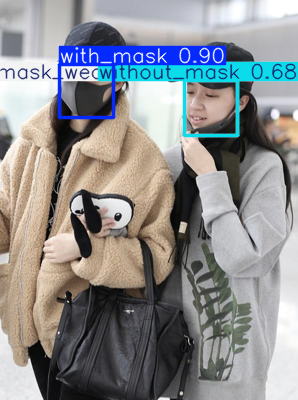


image 1/1 F:\FaceMaskDetection_Jupyter\dataset\images\val\maksssksksss550.png: 416x416 1 with_mask, 19.5ms
Speed: 3.2ms preprocess, 19.5ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)
maksssksksss550.png | With Mask: 1 | Without Mask: 0 | Incorrect: 0


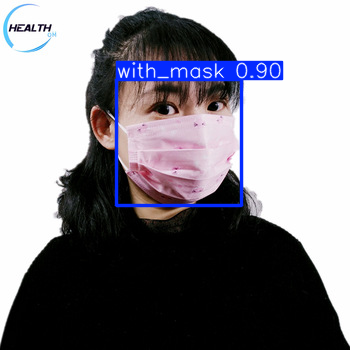


image 1/1 F:\FaceMaskDetection_Jupyter\dataset\images\val\maksssksksss752.png: 256x416 12 with_masks, 19.9ms
Speed: 3.4ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)
maksssksksss752.png | With Mask: 12 | Without Mask: 0 | Incorrect: 0


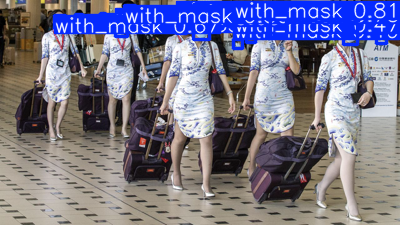


image 1/1 F:\FaceMaskDetection_Jupyter\dataset\images\val\maksssksksss533.png: 416x320 1 with_mask, 19.2ms
Speed: 1.9ms preprocess, 19.2ms inference, 4.2ms postprocess per image at shape (1, 3, 416, 320)
maksssksksss533.png | With Mask: 1 | Without Mask: 0 | Incorrect: 0


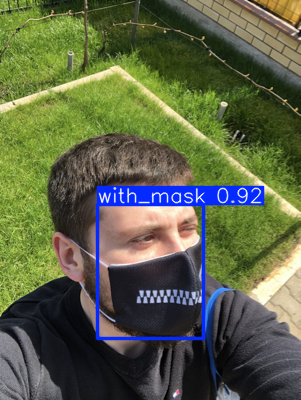


image 1/1 F:\FaceMaskDetection_Jupyter\dataset\images\val\maksssksksss14.png: 416x320 1 without_mask, 18.0ms
Speed: 1.9ms preprocess, 18.0ms inference, 3.5ms postprocess per image at shape (1, 3, 416, 320)
maksssksksss14.png | With Mask: 0 | Without Mask: 1 | Incorrect: 0


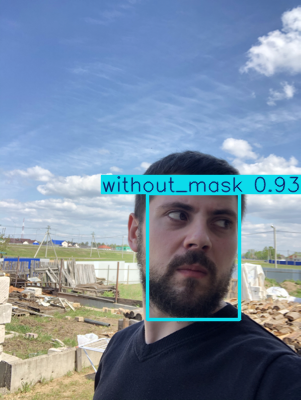


image 1/1 F:\FaceMaskDetection_Jupyter\dataset\images\val\maksssksksss839.png: 288x416 4 with_masks, 1 without_mask, 18.6ms
Speed: 2.2ms preprocess, 18.6ms inference, 3.3ms postprocess per image at shape (1, 3, 288, 416)
maksssksksss839.png | With Mask: 4 | Without Mask: 1 | Incorrect: 0


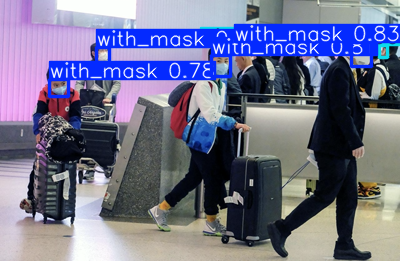


image 1/1 F:\FaceMaskDetection_Jupyter\dataset\images\val\maksssksksss494.png: 416x288 1 with_mask, 45.2ms
Speed: 4.1ms preprocess, 45.2ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 288)
maksssksksss494.png | With Mask: 1 | Without Mask: 0 | Incorrect: 0


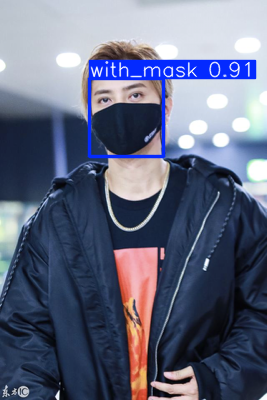


image 1/1 F:\FaceMaskDetection_Jupyter\dataset\images\val\maksssksksss382.png: 320x416 5 with_masks, 28.3ms
Speed: 2.5ms preprocess, 28.3ms inference, 4.2ms postprocess per image at shape (1, 3, 320, 416)
maksssksksss382.png | With Mask: 5 | Without Mask: 0 | Incorrect: 0


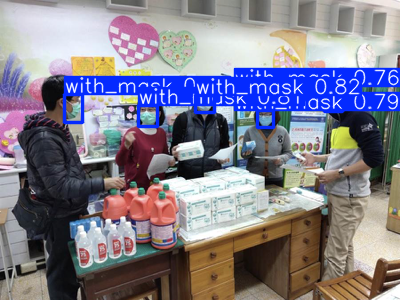


image 1/1 F:\FaceMaskDetection_Jupyter\dataset\images\val\maksssksksss552.png: 288x416 1 with_mask, 24.8ms
Speed: 2.8ms preprocess, 24.8ms inference, 3.7ms postprocess per image at shape (1, 3, 288, 416)
maksssksksss552.png | With Mask: 1 | Without Mask: 0 | Incorrect: 0


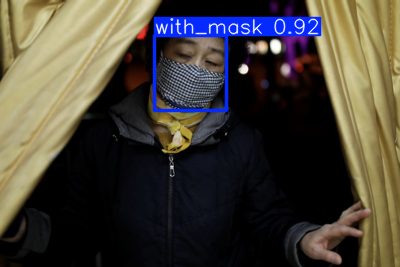


image 1/1 F:\FaceMaskDetection_Jupyter\dataset\images\val\maksssksksss573.png: 256x416 6 with_masks, 2 mask_weared_incorrects, 16.2ms
Speed: 1.6ms preprocess, 16.2ms inference, 2.1ms postprocess per image at shape (1, 3, 256, 416)
maksssksksss573.png | With Mask: 6 | Without Mask: 0 | Incorrect: 2


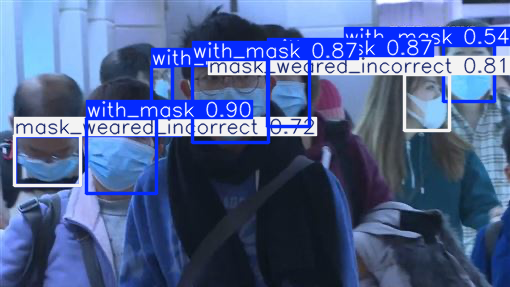


Total detections in sampled validation images:
with_mask: 32
without_mask: 3
mask_weared_incorrect: 3


In [26]:
import os
import random
import cv2
from PIL import Image
from IPython.display import display
from ultralytics import YOLO

# ===== Paths =====
yol_path = r'F:\FaceMaskDetection_Jupyter\runs\detect\mask_detector2\weights\best.pt'
images_dir = r'F:\FaceMaskDetection_Jupyter\dataset\images\val'
yaml_path = r'F:\FaceMaskDetection_Jupyter\face_mask.yaml'

# ===== Load trained model =====
model = YOLO(yol_path)

# ===== Evaluate on validation set =====
metrics = model.val(data=yaml_path, workers=0)

# ===== Extract metrics using mean_results() =====
precision, recall, mAP50, mAP50_95 = metrics.box.mean_results()
accuracy_approx = (precision + recall) / 2

print("=== Validation Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"mAP50: {mAP50:.4f}")
print(f"mAP50-95: {mAP50_95:.4f}")
print(f"Approximate Accuracy: {accuracy_approx:.4f}\n")

# ===== Select 10 random images =====
all_images = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
random_images = random.sample(all_images, min(10, len(all_images)))

print("=== Generating predictions on random validation images ===\n")

# ===== Initialize total counts for all sampled images =====
total_counts = {"with_mask": 0, "without_mask": 0, "mask_weared_incorrect": 0}

for img_name in random_images:
    img_path = os.path.join(images_dir, img_name)
    results = model(img_path)
    
    # Annotated image from YOLO (BGR)
    annotated_img = results[0].plot()
    
    # Convert BGR -> RGB for display
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(annotated_img)
    
    # Count detections per class
    counts = {"with_mask": 0, "without_mask": 0, "mask_weared_incorrect": 0}
    for box in results[0].boxes:
        cls = int(box.cls.cpu().numpy()[0])
        label = model.names[cls]
        counts[label] += 1
        total_counts[label] += 1
    
    # Display image and counts
    print(f"{img_name} | With Mask: {counts['with_mask']} | Without Mask: {counts['without_mask']} | Incorrect: {counts['mask_weared_incorrect']}")
    display(pil_img)

# ===== Total counts in sampled images =====
print("\nTotal detections in sampled validation images:")
for cls, cnt in total_counts.items():
    print(f"{cls}: {cnt}")
